In [1]:
import os
import time
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
class DownConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz,norm = True, dropout = 0.0):
        super(DownConvBlock,self).__init__()
        self.layers = [nn.Conv2d(ip_sz, op_sz, 4,2, 1)]
        
        if norm:
            self.layers.append(nn.InstanceNorm2d(op_sz))
        self.layers += [nn.LeakyReLU(0.2)]
        
        if dropout:
            self.layers += [nn.Dropout(dropout)]
    
    def forward(self,x):
        op = nn.Sequential(*(self.layers)).to(device)(x)
        return op

In [4]:
class UpConvBlock(nn.Module):
    def __init__(self, ip_sz, op_sz, dropout = 0.0):
        super(UpConvBlock, self).__init__()
        
        self.layers = [
            nn.ConvTranspose2d(ip_sz, op_sz , 4 , 2 , 1), # image size 확장
            nn.InstanceNorm2d(op_sz),
            nn.ReLU(),
        ]
        if dropout :
            self.layers += [nn.Dropout(dropout)]
    
    def forward(self, x , enc_ip): # enc_ip > Downconv 와 skip connection 
        x = nn.Sequential(*(self.layers)).to(device)(x)
        
        op = torch.cat((x, enc_ip) , 1 ) # channel concat
        return op

In [5]:
# 생성자
class Unet(nn.Module):
    def __init__(self,chnls_in = 3, chnls_op = 3 ): # in / out channel
        super(Unet,self).__init__()
        self.down_conv_layer1 = DownConvBlock(chnls_in, 64, norm = False)
        self.down_conv_layer2 = DownConvBlock(64, 128)
        self.down_conv_layer3 = DownConvBlock(128, 256)
        self.down_conv_layer4 = DownConvBlock(256, 512, dropout=0.5)
        self.down_conv_layer5 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer6 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer7 = DownConvBlock(512, 512, dropout=0.5)
        self.down_conv_layer8 = DownConvBlock(512, 512 , norm= False, dropout=0.5)
        
        # up
        self.up_conv_layer1 = UpConvBlock(512,512, dropout=0.5)
        self.up_conv_layer2 = UpConvBlock(1024,512, dropout=0.5)
        self.up_conv_layer3 = UpConvBlock(1024,512, dropout=0.5)
        self.up_conv_layer4 = UpConvBlock(1024,512, dropout=0.5)
        self.up_conv_layer5 = UpConvBlock(1024,256)
        self.up_conv_layer6 = UpConvBlock(512,128)
        self.up_conv_layer7 = UpConvBlock(256,64)
        
        self.upsample_layer = nn.Upsample(scale_factor = 2)
        self.zero_pad = nn.ZeroPad2d((1,0,1,0))
        self.conv_layer_1 = nn.Conv2d(128,chnls_op,4,padding= 1)
        self.activation = nn.Tanh()
        
    def forward(self,x):
        enc1 = self.down_conv_layer1(x).to(device)
        enc2 = self.down_conv_layer2(enc1)
        enc3 = self.down_conv_layer3(enc2)
        enc4 = self.down_conv_layer4(enc3)
        enc5 = self.down_conv_layer5(enc4)
        enc6 = self.down_conv_layer6(enc5)
        enc7 = self.down_conv_layer7(enc6)
        enc8 = self.down_conv_layer8(enc7)
        
        # decode
        dec1 = self.up_conv_layer1(enc8, enc7)
        dec2 = self.up_conv_layer2(dec1, enc6)
        dec3 = self.up_conv_layer3(dec2, enc5)
        dec4 = self.up_conv_layer4(dec3, enc4)
        dec5 = self.up_conv_layer5(dec4, enc3)
        dec6 = self.up_conv_layer6(dec5, enc2)
        dec7 = self.up_conv_layer7(dec6, enc1) # 256, 64, 64
        
        final = self.upsample_layer(dec7) # 256,128,128
        final = self.zero_pad(final)
        final = self.conv_layer_1(final)
        return self.activation(final)

In [6]:
#판별자

class Pix2PixDiscriminator(nn.Module):
    def __init__(self, chnls_in=3):
        super(Pix2PixDiscriminator, self).__init__()
        def disc_conv_block(chnls_in, chnls_op, norm=1):
            layers = [nn.Conv2d(chnls_in, chnls_op, 4, stride=2, padding=1)]
            if norm:
                layers.append(nn.InstanceNorm2d(chnls_op))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers).to(device)
        
        self.lyr1 = disc_conv_block(chnls_in * 2, 64, norm=0)
        self.lyr2 = disc_conv_block(64, 128)
        self.lyr3 = disc_conv_block(128, 256)
        self.lyr4 = disc_conv_block(256, 512)
        
    def forward(self, real_image, translated_image):
        ip = torch.cat((real_image, translated_image), 1)
        op = self.lyr1(ip)
        op = self.lyr2(op)
        op = self.lyr3(op)
        op = self.lyr4(op)
        op = nn.ZeroPad2d((1, 0, 1, 0)).to(device)(op)
        op = nn.Conv2d(512, 1, 4, padding=1).to(device)(op)

        return torch.sigmoid(op)

In [7]:
# dataset 생성
class FacedeDataset(Dataset):
    def __init__(self, path2img, direciton = "b2a" , transform = False):
        super(FacedeDataset, self).__init__()
        self.direction = direciton
        self.path2a = os.path.join(path2img,"a")
        self.path2b = os.path.join(path2img,"b")
        self.img_filenames = [x for x in os.listdir(self.path2a)]
        self.transform = transform
    
    def __getitem__(self,index):
        a = Image.open(os.path.join(self.path2a,self.img_filenames[index])).convert("RGB")
        b = Image.open(os.path.join(self.path2b,self.img_filenames[index])).convert("RGB")
        
        if self.transform:
            a = self.transform(a)
            b = self.transform(b)
        
        if self.direction == "b2a":
            return b,a
        else:
            return a,b
        
    def __len__(self):
        return len(self.img_filenames)

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
    
])

In [9]:
# dataset 구성
path2img = "./facades/train"
train_ds = FacedeDataset(path2img, transform=transform)

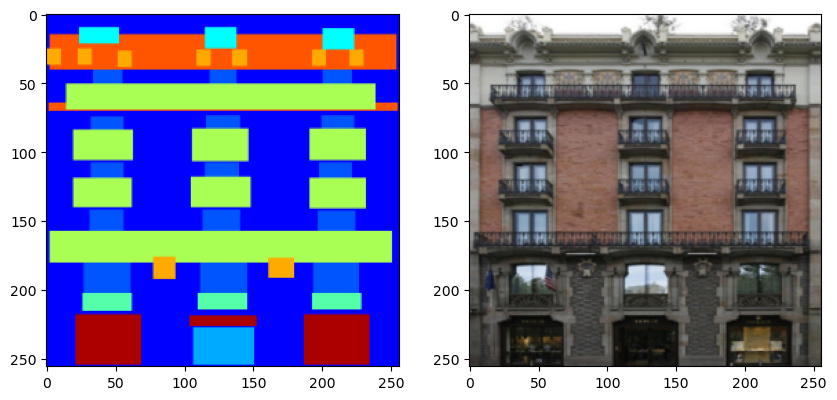

In [10]:
import matplotlib.pyplot as plt
# 샘플 이미지 확인
# 왼쪽 그림을 보고 오른쪽 실제 이미지처럼 바꾸는것이 pix2pix
a,b = train_ds[0]
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(to_pil_image(0.5*a+0.5))
plt.subplot(1,2,2)
plt.imshow(to_pil_image(0.5*b+0.5))

In [11]:
# 데이터 로더 생성
train_dl = DataLoader(train_ds, batch_size=32 , shuffle= True)

In [12]:
# 학습 (train)

loss_func_gan = nn.BCELoss().to(device)
loss_func_pix = nn.L1Loss().to(device)

lambda_pixel = 100 
patch = (1,256//2**4,256//2**4)

In [13]:
from torch import optim
lr = 2e-4
beta1 = 0.5
beta2 = 0.999
model_gan = Unet().to(device)
model_dis = Pix2PixDiscriminator().to(device)
opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,beta2))
opt_gan = optim.Adam(model_gan.parameters(),lr=lr,betas=(beta1,beta2))

In [15]:
# train

model_gan.train()
model_dis.train()

batch_count = 0
num_epochs = 100
start_time = time.time()

loss_hit = {"gan":[], "dis":[]}

for epoch in range(num_epochs):
    for a, b in train_dl:
        a = a.to(device)
        b = b.to(device)
        ba_si = a.size(0)
        #real image
        real_a = a.to(device)
        real_b = b.to(device)
        # patch label
        real_label = torch.ones(ba_si, *patch, requires_grad=False).to(device)
        fake_label = torch.zeros(ba_si,  *patch,requires_grad=False).to(device)
        
        model_gan.zero_grad()

        fake_b = model_gan(real_a).to(device) # 가짜 이미지 생성
        
        out_dis = model_dis(fake_b, real_b).to(device) # 가짜 이미지 식별
        gan_loss = loss_func_gan(out_dis, real_label) 
        
        pixel_loss = loss_func_pix(fake_b, real_b) # 가짜 이미지와 실제 이미지 pixel mse 차이
        g_loss = gan_loss + lambda_pixel * pixel_loss
        g_loss.backward()
        # 생성자 학습
        opt_gan.step()
        
        
        # 판별자
        model_dis.zero_grad()
        out_dis = model_dis(real_b,real_a).to(device) # 진짜 이미지 식별
        real_loss = loss_func_gan(out_dis, real_label)
        
        out_dis = model_dis(fake_b.detach() , real_a).to(device) # 가짜 이미지 식별
        fake_loss = loss_func_gan(out_dis,fake_label)

        
        d_loss = (real_loss + fake_loss) / 2.
        d_loss.backward()
        opt_dis.step()
        
        loss_hit["gan"].append(g_loss.item())
        loss_hit["dis"].append(d_loss.item())


        batch_count += 1
        if batch_count % 100 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, g_loss.item(), d_loss.item(), (time.time()-start_time)/60))
        

Epoch: 7, G_Loss: 40.202820, D_Loss: 0.717268, time: 1.19 min
Epoch: 15, G_Loss: 37.119858, D_Loss: 0.672824, time: 2.34 min
Epoch: 23, G_Loss: 37.881653, D_Loss: 0.727908, time: 3.48 min
Epoch: 30, G_Loss: 39.019146, D_Loss: 0.791807, time: 4.63 min
Epoch: 38, G_Loss: 36.906185, D_Loss: 0.742768, time: 5.77 min
Epoch: 46, G_Loss: 38.348816, D_Loss: 0.697998, time: 6.90 min
Epoch: 53, G_Loss: 36.088509, D_Loss: 0.649782, time: 8.04 min
Epoch: 61, G_Loss: 38.097309, D_Loss: 0.790159, time: 9.17 min


KeyboardInterrupt: 

In [17]:
model_gan.eval()

# 가짜 이미지 생성
with torch.no_grad():
    for a,b in train_dl:
        fake_imgs = model_gan(a.to(device)).detach().cpu()
        real_imgs = b
        break

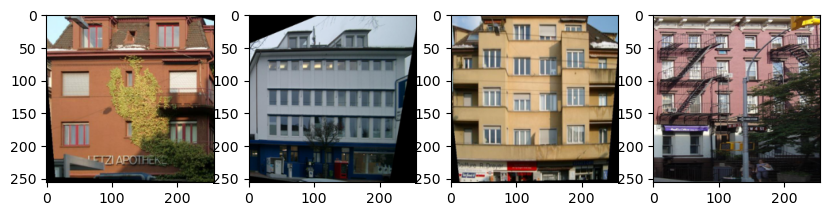

In [27]:
plt.figure(figsize=(10,10))

for ii in range(0,4,1):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*real_imgs[ii]+0.5))

In [29]:
real_imgs[0].size()

torch.Size([3, 256, 256])

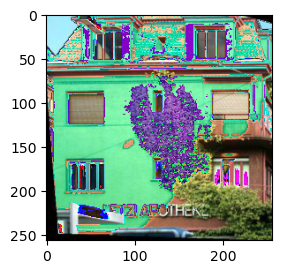

In [42]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(to_pil_image(real_imgs[0]) , cmap='gray')
    #(real_imgs[0] * 0.5).permute(1,2,0))

In [41]:
real_imgs[0].shape

torch.Size([3, 256, 256])

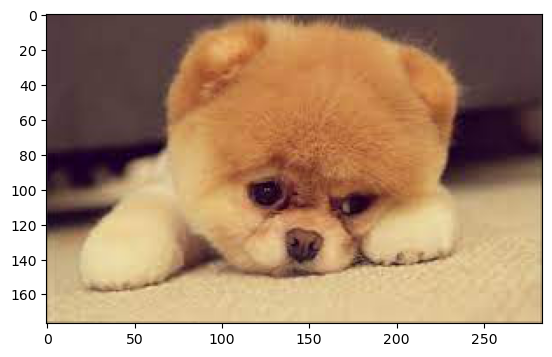

In [43]:
plt.imshow(plt.imread("./download.jpg"))

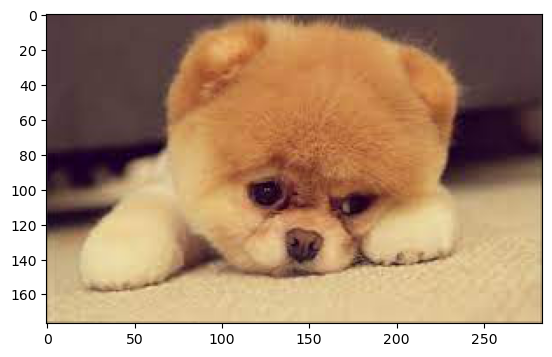

In [45]:
import matplotlib.pyplot as plt
fileName = "./download.jpg"

ndarray = plt.imread(fileName)

plt.imshow(ndarray)

plt.show()